# Using ModelBuilder class for deploying PyMC models 
:::{post} Feb 22, 2023
:tags: deployment
:category: Advanced
:author: Shashank Kirtania, Thomas Wiecki, Michał Raczycki
:::

## Motivation

Many users face difficulty in deploying their PyMC models to production because deploying/saving/loading a user-created model is not well standardized. One of the reasons behind this is there is no direct way to save or load a model in PyMC like scikit-learn or TensorFlow. The new `ModelBuilder` class is aimed to improve this workflow by providing a scikit-learn inspired API to wrap your PyMC models.

The new `ModelBuilder` class allows users to use methods to `fit()`, `predict()`, `save()`, `load()`. Users can create any model they want, inherit the `ModelBuilder` class, and use predefined methods.

Let's go through the full workflow, starting with a simple linear regression PyMC model as it's usually written. Of course, this model is just a place-holder for your own model.

In [1]:
from typing import Dict, List, Optional, Tuple, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from numpy.random import RandomState

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927

rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [2]:
# Generate data
x = np.linspace(start=0, stop=1, num=100)
y = 0.3 * x + 0.5 + rng.normal(0, 1, len(x))

## Standard syntax
Usually a PyMC model will have this form:

In [3]:
with pm.Model() as model:
    # priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    eps = pm.HalfNormal("eps", 1.0)

    # observed data
    y_model = pm.Normal("y_model", mu=a + b * x, sigma=eps, observed=y)

    # Fitting
    idata = pm.sample()
    idata.extend(pm.sample_prior_predictive())

    # posterior predict
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [a, b, eps, y_model]


How would we deploy this model? Save the fitted model, load it on an instance, and predict? Not so simple.

`ModelBuilder` is built for this purpose. It is currently part of the  `pymc-experimental` package which we can pip install with `pip install pymc-experimental`. As the name implies, this feature is still experimental and subject to change.

## Model builder class

Let's import the `ModelBuilder` class.

In [4]:
from pymc_experimental.model_builder import ModelBuilder

To define our desired model we inherit from the `ModelBuilder` class. There are a couple of methods we need to define.

In [5]:
class LinearModel(ModelBuilder):
    # Give the model a name
    _model_type = "LinearModel"

    # And a version
    version = "0.1"

    def build_model(self, X: pd.DataFrame, y: Union[pd.Series, np.ndarray], **kwargs):
        """
        build_model creates the PyMC model

        Parameters:
        model_config: dictionary
            it is a dictionary with all the parameters that we need in our model example:  a_loc, a_scale, b_loc
        data: Dict[str, Union[np.ndarray, pd.DataFrame, pd.Series]]
            Data we want our model fit on.
        """
        # Check the type of X and y and adjust access accordingly
        X_values = X["input"].values
        y_values = y.values if isinstance(y, pd.Series) else y
        self._generate_and_preprocess_model_data(X_values, y_values)

        with pm.Model(coords=self.model_coords) as self.model:

            # Create mutable data containers
            x_data = pm.MutableData("x_data", X_values)
            y_data = pm.MutableData("y_data", y_values)

            # prior parameters
            a_mu_prior = self.model_config.get("a_mu_prior", 0.0)
            a_sigma_prior = self.model_config.get("a_sigma_prior", 1.0)
            b_mu_prior = self.model_config.get("b_mu_prior", 0.0)
            b_sigma_prior = self.model_config.get("b_sigma_prior", 1.0)
            eps_prior = self.model_config.get("eps_prior", 1.0)

            # priors
            a = pm.Normal("a", mu=a_mu_prior, sigma=a_sigma_prior)
            b = pm.Normal("b", mu=b_mu_prior, sigma=b_sigma_prior)
            eps = pm.HalfNormal("eps", eps_prior)

            obs = pm.Normal("y", mu=a + b * x_data, sigma=eps, shape=x_data.shape, observed=y_data)

    def _data_setter(
        self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray] = None
    ):
        if isinstance(X, pd.DataFrame):
            x_values = X["input"].values
        else:
            # Assuming "input" is the first column
            x_values = X[:, 0]

        with self.model:
            pm.set_data({"x_data": x_values})
            if y is not None:
                pm.set_data({"y_data": y.values if isinstance(y, pd.Series) else y})

    @property
    def default_model_config(self) -> Dict:
        """
        default_model_config is a property that returns a dictionary with all the prior values we want to build the model with.
        It supports more complex data structures like lists, dictionaries, etc.
        It will be passed to the class instance on initialization, in case the user doesn't provide any model_config of their own.
        """
        model_config: Dict = {
            "a_mu_prior": 0.0,
            "a_sigma_prior": 1.0,
            "b_mu_prior": 0.0,
            "b_sigma_prior": 1.0,
            "eps_prior": 1.0,
        }
        return model_config

    @property
    def default_sampler_config(self) -> Dict:
        """
        default_sampler_config is a property that returns a dictionary with all most important sampler parameters.
        It will be used in case the user doesn't provide any sampler_config of their own.
        """
        sampler_config: Dict = {
            "draws": 1_000,
            "tune": 1_000,
            "chains": 3,
            "target_accept": 0.95,
        }
        return sampler_config

    @property
    def output_var(self):
        return "y"

    @property
    def _serializable_model_config(self) -> Dict[str, Union[int, float, Dict]]:
        """
        _serializable_model_config is a property that returns a dictionary with all the model parameters that we want to save.
        as some of the data structures are not json serializable, we need to convert them to json serializable objects.
        Some models will need them, others can just define them to return the model_config.
        """
        return self.model_config

    def _save_input_params(self, idata) -> None:
        """
        Saves any additional model parameters (other than the dataset) to the idata object.

        These parameters are stored within `idata.attrs` using keys that correspond to the parameter names.
        If you don't need to store any extra parameters, you can leave this method unimplemented.

        Example:
            For saving customer IDs provided as an 'customer_ids' input to the model:
            self.customer_ids = customer_ids.values #this line is done outside of the function, preferably at the initialization of the model object.
            idata.attrs["customer_ids"] = json.dumps(self.customer_ids.tolist())  # Convert numpy array to a JSON-serializable list.
        """
        pass

        pass

    def _generate_and_preprocess_model_data(
        self, X: Union[pd.DataFrame, pd.Series], y: Union[pd.Series, np.ndarray]
    ) -> None:
        """
        Depending on the model, we might need to preprocess the data before fitting the model.
        all required preprocessing and conditional assignments should be defined here.
        """
        self.model_coords = None  # in our case we're not using coords, but if we were, we would define them here, or later on in the function, if extracting them from the data.
        # as we don't do any data preprocessing, we just assign the data givenin by the user. Note that it's very basic model,
        # and usually we would need to do some preprocessing, or generate the coords from the data.
        self.X = X
        self.y = y

Now we can create the `LinearModel` object. First step we need to take care of, is data generation:

In [6]:
X = pd.DataFrame(data=np.linspace(start=0, stop=1, num=100), columns=["input"])
y = 0.3 * x + 0.5
y = y + np.random.normal(0, 1, len(x))

model = LinearModel()

After making the object of class `LinearModel` we can fit the model using the `.fit()` method.

## Fitting to data

The `fit()` method takes one argument `data` on which we need to fit the model. The meta-data is saved in the `InferenceData` object where also the trace is stored. These are the fields that are stored:

* `id` : This is a unique id given to a model based on model_config, sample_conifg, version, and model_type. Users can use it to check if the model matches to another model they have defined.
* `model_type` : Model type tells us what kind of model it is. This in this case it outputs **Linear Model** 
* `version` : In case you want to improve on models, you can keep track of model by their version. As the version changes the unique hash in the `id` also changes.
* `sample_conifg` : It stores values of the sampler configuration set by user for this particular model.
* `model_config` : It stores values of the model configuration set by user for this particular model.


In [7]:
idata = model.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [a, b, eps, y]


## Saving model to file

After fitting the model, we can probably save it to share the model as a file so one can use it again.
To `save()` or `load()`, we can quickly call methods for respective tasks with the following syntax.

In [8]:
fname = "linear_model_v1.nc"
model.save(fname)

This saves a file at the given path, and the name <br>
A NetCDF `.nc` file that stores the inference data of the model.

## Loading a model

Now if we wanted to deploy this model, or just have other people use it to predict data, they need two things:
1. the `LinearModel` class (probably in a .py file)
2. the linear_model_v1.nc file

With these, you can easily load a fitted model in a different environment (e.g. production):

In [9]:
model_2 = LinearModel.load(fname)

/pymc-marketing/.conda/envs/pymc-marketing/lib/python3.10/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


Note that `load()` is a class-method, we do not need to instantiate the `LinearModel` object.

In [10]:
type(model_2)

__main__.LinearModel

## Prediction

Next we might want to predict on new data. The `predict()` method allows users to do posterior prediction with the fitted model on new data.

Our first task is to create data on which we need to predict.

In [11]:
x_pred = np.random.uniform(low=1, high=2, size=10)
prediction_data = pd.DataFrame({"input": x_pred})
type(prediction_data["input"].values)

numpy.ndarray

`ModelBuilder` provides two methods for prediction:
1. point estimates (the mean) with `predict()`
2. full posterior prediction (samples) with `predict_posterior()`

In [12]:
pred_mean = model_2.predict(prediction_data)
# samples
pred_samples = model_2.predict_posterior(prediction_data)

After using the `predict()`, we can plot our data and see graphically how satisfactory our `LinearModel` is.

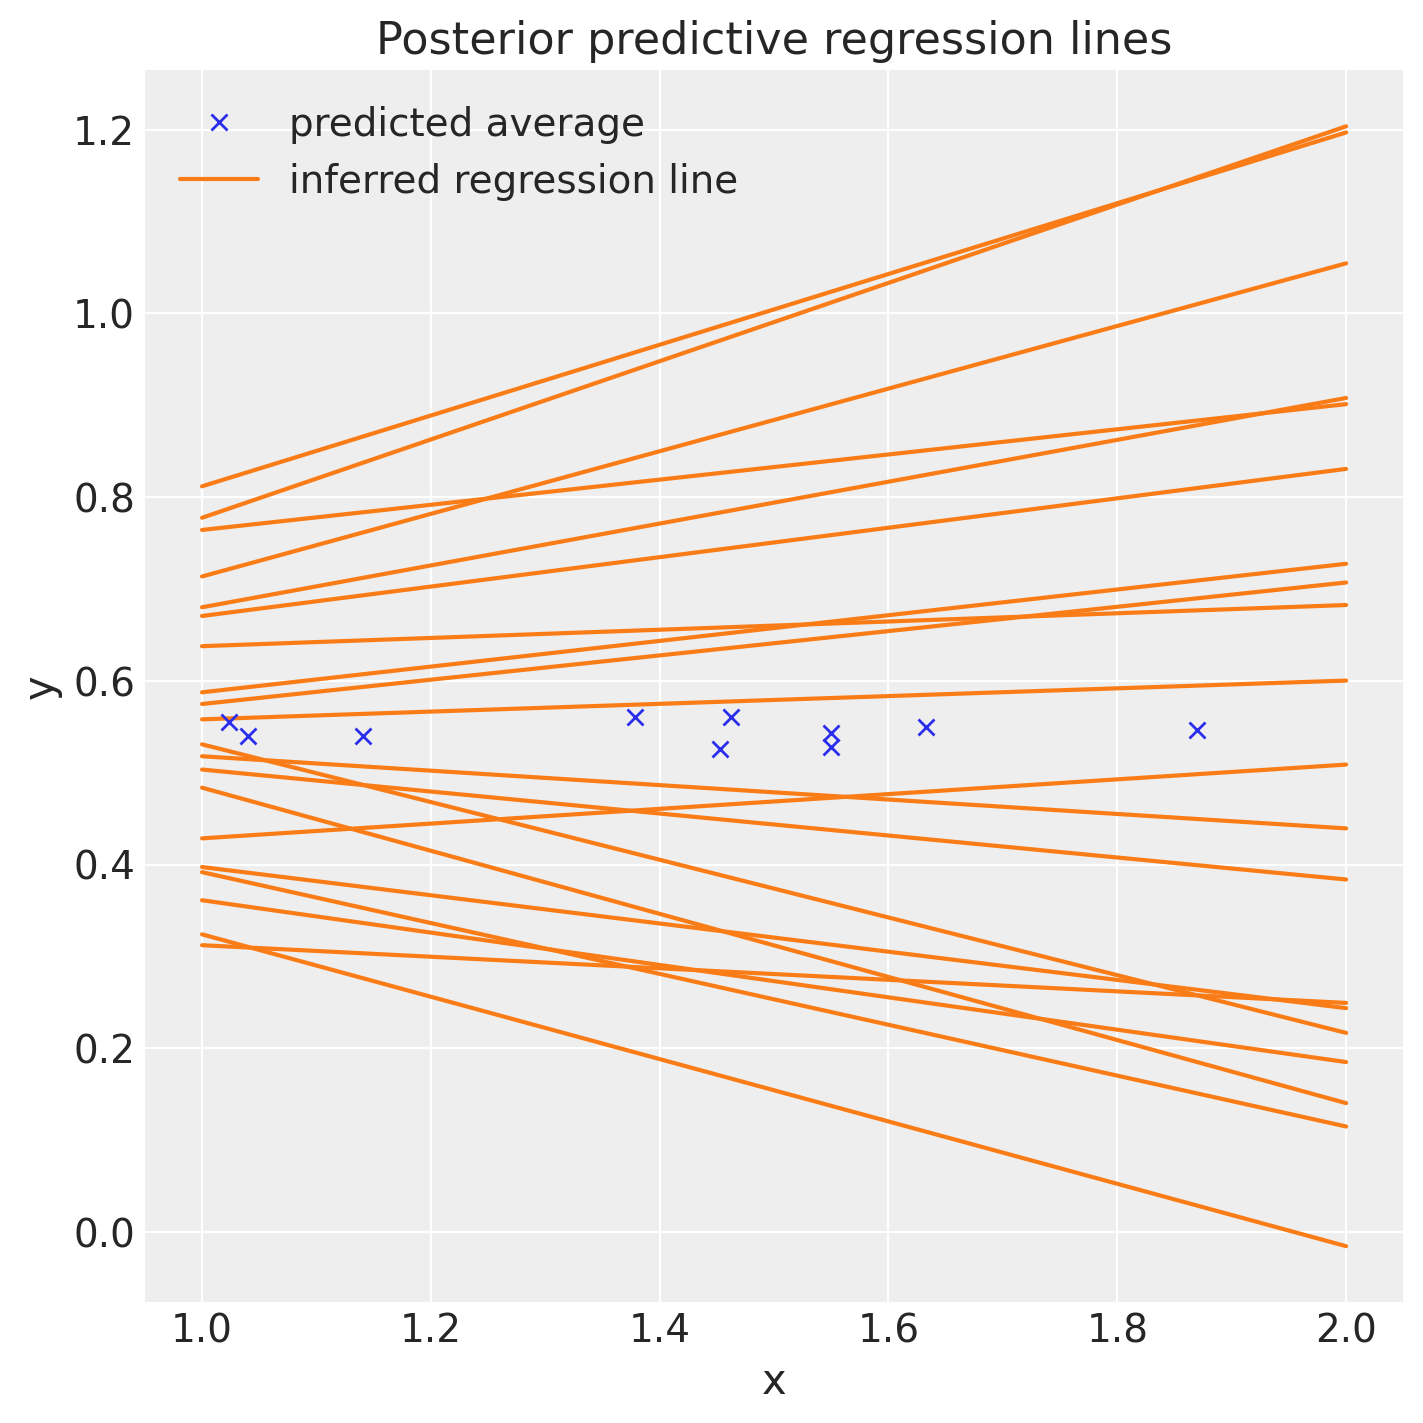

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
posterior = az.extract(idata, num_samples=20)
x_plot = xr.DataArray(np.linspace(1, 2, 100))
y_plot = posterior["b"] * x_plot + posterior["a"]
Line2 = ax.plot(x_plot, y_plot.transpose(), color="C1")
Line1 = ax.plot(x_pred, pred_mean, "x")
ax.set(title="Posterior predictive regression lines", xlabel="x", ylabel="y")
ax.legend(
    handles=[Line1[0], Line2[0]], labels=["predicted average", "inferred regression line"], loc=0
);

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_experimental

Last updated: Wed Aug 23 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

pymc_experimental: 0.0.11

xarray    : 2023.7.0
arviz     : 0.16.1
pandas    : 2.0.3
numpy     : 1.25.1
matplotlib: 3.7.2
pymc      : 5.6.1

Watermark: 2.4.3



## Authors
* Authored by Shashank Kirtania and Thomas Wiecki in 2023.
* Modified and updated by Michał Raczycki in 08/2023

:::{include} ../page_footer.md
:::